In [1]:
import os
import sys
import csv
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import math
import cv2
import sklearn
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models
from sklearn.svm import OneClassSVM
from deep_svdd import BaseSVDD
from scipy.spatial import distance
from sklearn.metrics import DistanceMetric

ImportError: cannot import name 'DistanceMetric' from 'sklearn.metrics' (C:\Users\kitam\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [2]:
%%time
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im
    
X_train = X_train/255
X_test_good = X_test_good/255
X_test_error = X_test_error/255
x_train, x_test = train_test_split(X_train, test_size=0.2)
X_test = np.concatenate([X_test_good, X_test_error])

CPU times: total: 12.1 s
Wall time: 17.2 s
CPU times: total: 12.1 s
Wall time: 17.2 s


In [ ]:
image_height, image_width = 256,256
input_shape = (256,256, 3)

model = models.Sequential()

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(16, kernel_size=(3, 3),activation='relu',padding='same',strides=2))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(8, kernel_size=(3, 3),activation='relu',padding='same', strides=2))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))


model.add(layers.Conv2D(8, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))

# model.add(layers.Conv2D(16, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(layers.Conv2DTranspose(16, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
model.add(layers.UpSampling2D(size=(2, 2)))

# model.add(layers.Conv2D(64, kernel_size=(3, 3),activation='sigmoid', padding='same'))
model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
model.compile(optimizer='adam',loss='binary_crossentropy')
model.summary()

model.fit(X_train, X_train,epochs=30,batch_size=64,shuffle=True,validation_data=(x_test, x_test))
score = model.evaluate(x_test, x_test, verbose=0)
print('test xentropy:', score)

Model: "sequential"
Model: "sequential"
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        9232      
                                                                 
 )                                  

In [ ]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',
                loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(7):
    encoder.pop()

X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
X_ts = encoder.predict(X_test,verbose=0)

x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

y_tr = np.ones(len(X_tr))
y_tg = np.ones(len(X_tg))
y_te = []
for i in range(len(x_te)):
    y_te.append(-1)
y_te = np.array(y_te)
y_ts = np.concatenate([y_tg, y_te])

y_tr = np.reshape(y_tr,(X_tr.shape[0], 1))
y_tg = np.reshape(y_tg,(X_tg.shape[0], 1))
y_te = np.reshape(y_te,(X_te.shape[0], 1))
y_ts = np.reshape(y_ts,(X_ts.shape[0], 1))

In [7]:
%%time
def mahalanobis_kernel(x,y):
    gamma=1
    cov = np.cov(x.T, bias=True)
    cov_i = np.linalg.pinv(cov)
    dist = DistanceMetric.get_metric('mahalanobis', VI=cov_i)
    cal = dist.pairwise(x) / 209*512
    return cal

CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
# m, n = x_tr.shape
# o, p = x_ts.shape
# cmat = np.zeros((o,n-p))
# cmat.shape
# x_ts = np.concatenate([x_ts, cmat], axis=1)

58 5
3 17
accuracy: 90.36144578313254
CPU times: total: 62.5 ms
Wall time: 71.4 ms


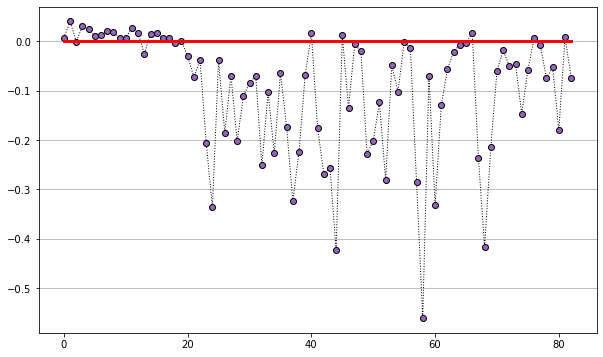

In [20]:
%%time
# clf = OneClassSVM(nu=2**(-1), kernel="linear")
# clf = OneClassSVM(nu=2**(-1), kernel="poly", degree=5, coef0=2)
clf = OneClassSVM(nu=2**(-3), kernel="rbf", gamma='scale')
# clf = OneClassSVM(nu=2**(-3), kernel="rbf", gamma='auto')
# clf = OneClassSVM(nu=2**(-5), kernel=mahalanobis_kernel)
# clf = OneClassSVM(nu=2**(-1), kernel="sigmoid", gamma='auto')
# clf = OneClassSVM(nu=2**(-1), kernel="precomputed", gamma='scale')

clf.fit(x_tr)
dis = clf.decision_function(x_ts)
pred_tr = clf.predict(x_tr)
pred_ts = clf.predict(x_ts)

pred_tg = clf.predict(x_tg)
pred_te = clf.predict(x_te)

index_tr = np.where(pred_tr < 0)
index_tg = np.where(pred_tg < 0)
index_te = np.where(pred_te < 0)
index_ts = np.where(pred_ts < 0)

# index_ts = np.where(dis > 0)

a = np.zeros(83)
plt.figure(figsize=(10, 6))
plt.grid(axis='y')
plt.plot(dis,color='k', linestyle=':', marker='o', linewidth=1, markeredgecolor='k', markerfacecolor='C4', markersize=6)
plt.plot(a,color='r', linestyle='-', marker='None', linewidth=3, markeredgecolor='k', markerfacecolor='w', markersize=6)
in_tg = np.array(index_tg)
in_te = np.array(index_te)
in_tr = np.array(index_tr)
in_ts = np.array(index_ts)
a0, b0 = in_tg.shape
a1, b1 = in_te.shape

TN = len(x_tg) - b0
FP = b0
FN = len(x_te) - b1
TP = b1
print(TP, FN)
print(FP, TN)
print('accuracy:',(TP + TN)/(TP+TN+FP+FN)*100)
# print('accuracy:',acc)



*** Fitting of the SVDD model is completed. ***

running time         = 0.1575 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.0727
number of samples    = 209
number of features   = 512
number of SVs        = 37
ratio of SVs         = 17.7033 %
accuracy             = 93.7799 %




*** Prediction of the provided data is completed. ***

running time         = 0.0000 seconds
number of samples    = 83
number of alarm      = 56
accuracy             = 89.1566 %




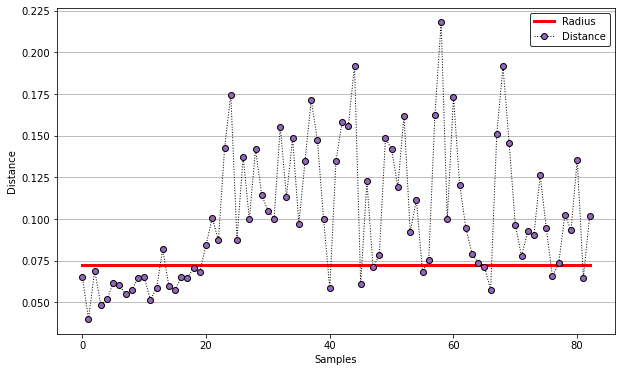

CPU times: total: 1.19 s
Wall time: 784 ms


In [43]:
%%time
# svdd = BaseSVDD(C=2**(-1), kernel='linear', display='on')
# svdd = BaseSVDD(C=2**(-1), degree=8, kernel='poly', coef0=2, display='on')
svdd = BaseSVDD(C=2**(-5), gamma='scale', kernel='rbf', display='on')
# svdd = BaseSVDD(C=2**(-4), gamma='auto', kernel='rbf', display='on')
# svdd = BaseSVDD(C=2**(-1), gamma='scale', kernel='sigmoid', display='on')
# svdd = BaseSVDD(C=2**(-5), kernel=mahalanobis_kernel,display='on')

svdd.fit(x_tr, y_tr)
pre_s = svdd.predict(x_ts, y_ts)
radius = svdd.radius

distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C

m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :, :, :]))
  else:
    NSV.append(list(X_train[i, :, :, :]))

sv = np.array(SV)
nsv = np.array(NSV)

In [127]:
s_v = np.array(clf.support_)
SV = []
for i in range(len(s_v)):
    SV.append(list(X_train[s_v[i], :, :, :]))
sv = np.array(SV)

In [44]:
model.fit(sv, sv,epochs=30,batch_size=32,shuffle=True,validation_data=(X_train, X_train))
score = model.evaluate(x_test, x_test, verbose=0)
print('test xentropy:', score)

Epoch 1/30
2/2 [==============================] - 15s 9s/step - loss: 0.4011 - val_loss: 0.4020
Epoch 2/30
2/2 [==============================] - 15s 9s/step - loss: 0.4012 - val_loss: 0.4051
Epoch 3/30
2/2 [==============================] - 17s 11s/step - loss: 0.4039 - val_loss: 0.4018
Epoch 4/30
2/2 [==============================] - 15s 9s/step - loss: 0.4010 - val_loss: 0.4007
Epoch 5/30
2/2 [==============================] - 15s 9s/step - loss: 0.3999 - val_loss: 0.4012
Epoch 6/30
2/2 [==============================] - 14s 9s/step - loss: 0.4002 - val_loss: 0.4028
Epoch 7/30
2/2 [==============================] - 14s 9s/step - loss: 0.4015 - val_loss: 0.4018
Epoch 8/30
2/2 [==============================] - 14s 9s/step - loss: 0.4006 - val_loss: 0.4010
Epoch 9/30
2/2 [==============================] - 14s 9s/step - loss: 0.3998 - val_loss: 0.4007
Epoch 10/30
2/2 [==============================] - 14s 9s/step - loss: 0.3997 - val_loss: 0.3994
Epoch 11/30
2/2 [=====================

In [45]:
encoder = models.clone_model(model)
encoder.compile(optimizer='adam',
                loss='binary_crossentropy')
encoder.set_weights(model.get_weights())
for i in range(7):
    encoder.pop()

X_tr = encoder.predict(X_train,verbose=0)
X_tg = encoder.predict(X_test_good,verbose=0)
X_te = encoder.predict(X_test_error,verbose=0)
X_ts = encoder.predict(X_test,verbose=0)
x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_tr)
f_train = pca.transform(x_tr)

pca.fit(x_tg)
f_test_0 = pca.transform(x_tg)

pca.fit(x_te)
f_test_1 = pca.transform(x_te)

# plt.figure(figsize=(8, 8))

# plt.scatter(f_train[:, 0], f_train[:, 1], alpha=0.8, c='b', s = 20)
# plt.scatter(f_test_0[:, 0], f_test_0[:, 1], alpha=0.8, c='g', s = 20)
# plt.scatter(f_test_1[:, 0], f_test_1[:, 1], alpha=0.8, c='black', s = 20)

# plt.grid()
# plt.xlabel("PC1_0")
# plt.ylabel("PC2_0")
# plt.show()

In [ ]:
clf.fit(x_tr)
pred_tr_sv = clf.predict(x_tr)
pred_tg_sv = clf.predict(x_tg)
pred_te_sv = clf.predict(x_te)

index_tr_sv = np.where(pred_tr_sv < 0)
index_tg_sv = np.where(pred_tg_sv < 0)
index_te_sv = np.where(pred_te_sv < 0)

plt.figure(figsize=(8, 8))
plt.scatter(f_train[:, 0], f_train[:, 1],c='b')
plt.scatter(f_train[index_tr_sv, 0], f_train[index_tr_sv, 1], c='red', label='outlair')

plt.scatter(f_test_0[:, 0], f_test_0[:, 1],c='g')
plt.scatter(f_test_0[index_tg_sv, 0], f_test_0[index_tg_sv, 1], c='red')

plt.scatter(f_test_1[:, 0], f_test_1[:, 1],c='black')
plt.scatter(f_test_1[index_te_sv, 0], f_test_1[index_te_sv, 1], c='red')

plt.legend()
plt.show()

in_tg_sv = np.array(index_tg_sv)
in_te_sv = np.array(index_te_sv)

a0, b0 = in_tg_sv.shape
a1, b1 = in_te_sv.shape

TN = len(x_tg) - b0
FP = b0
FN = len(x_te) - b1
TP = b1
print(TP, FN)
print(FP, TN)
print('accuracy:',(TP + TN)/(TP+TN+FP+FN)) 

In [56]:
a = mahalanobis_kernel(x_tr, 1)
b = mahalanobis_kernel(x_ts, 1)

In [51]:
a.shape

(209, 209)



*** Fitting of the SVDD model is completed. ***

running time         = 0.2707 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.5226
number of samples    = 209
number of features   = 512
number of SVs        = 16
ratio of SVs         = 7.6555 %
accuracy             = 98.5646 %




*** Prediction of the provided data is completed. ***

running time         = 0.0156 seconds
number of samples    = 83
number of alarm      = 55
accuracy             = 87.9518 %




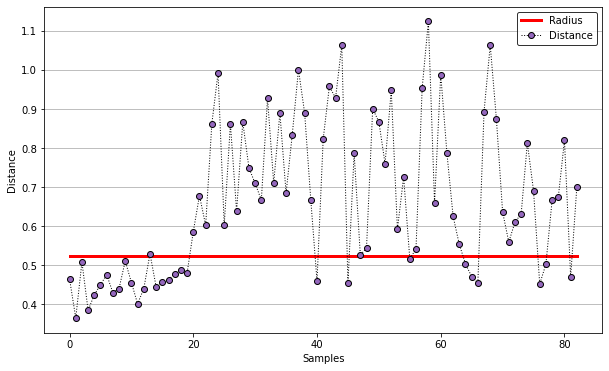

CPU times: total: 1.58 s
Wall time: 936 ms


In [72]:
%%time
# svdd = BaseSVDD(C=2**(-1), kernel='linear', display='on')
# svdd = BaseSVDD(C=2**(-1), degree=8, kernel='poly', coef0=2, display='on')
svdd = BaseSVDD(C=2**(-3), gamma='scale', kernel='rbf', display='on')
# svdd = BaseSVDD(C=2**(-2), gamma='auto', kernel=, display='on')
# svdd = BaseSVDD(C=2**(-1), gamma='scale', kernel='sigmoid', display='on')
# svdd = BaseSVDD(C=2**(-5), kernel='cosine', gamma='scale',display='on')

svdd.fit(x_tr, y_tr)
pre_s = svdd.predict(x_ts, y_ts)
radius = svdd.radius

distance = svdd.get_distance(x_ts)
svdd.plot_distance(radius, distance)

alphas = svdd.alpha
Param = svdd.C

m, n = x_tr.shape
SV = []
NSV = []
for i in range(m):
  if alphas[i] > 0 and alphas[i] <= Param[0]:
    SV.append(list(X_train[i, :, :, :]))
  else:
    NSV.append(list(X_train[i, :, :, :]))

sv = np.array(SV)
nsv = np.array(NSV)